In [10]:
import numpy as np
import pickle
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, concatenate, Activation,GlobalAveragePooling2D, Concatenate, Conv2DTranspose, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import h5py

In [2]:
# h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/slices_dataset.h5'
# train_h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/train_dataset.h5'
# test_h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/test_dataset.h5'

# # Open the existing HDF5 file in read-only mode
# data = h5py.File(h5_file, 'r')
# samples = data['samples']
# labels = data['labels']

# train_indices, test_indices = train_test_split(
#     np.arange(len(labels)), test_size=0.2, stratify=labels, shuffle=True
# )

# train_indices = np.sort(train_indices)
# test_indices = np.sort(test_indices)

# # Save train dataset to a new HDF5 file
# train_data = h5py.File(train_h5_file, 'w')
# train_samples = train_data.create_dataset('samples', shape=samples[train_indices].shape, dtype=samples.dtype)
# train_labels = train_data.create_dataset('labels', shape=labels[train_indices].shape, dtype=labels.dtype)

# # Iterate over train_indices and save the corresponding samples and labels
# for i, idx in enumerate(train_indices):
#     train_samples[i] = samples[idx]
#     train_labels[i] = labels[idx]

# train_data.close()

# # Save test dataset to a new HDF5 file
# test_data = h5py.File(test_h5_file, 'w')
# test_samples = test_data.create_dataset('samples', shape=samples[test_indices].shape, dtype=samples.dtype)
# test_labels = test_data.create_dataset('labels', shape=labels[test_indices].shape, dtype=labels.dtype)

# # Iterate over test_indices and save the corresponding samples and labels
# for i, idx in enumerate(test_indices):
#     test_samples[i] = samples[idx]
#     test_labels[i] = labels[idx]

# test_data.close()



In [22]:
h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/slices_dataset.h5'
train_h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/train_dataset.h5'
test_h5_file = 'D:/SIIUM/3 semestr/RADAR/radar-project/notebooks/instance_classification/test_dataset.h5'

class CustomDataGenerator(tf.keras.utils.Sequence):
    """
    Custom data generator class
    """
    def __init__(self, h5_file, batch_size=128):
        self.h5_file = h5_file
        self.batch_size = batch_size
        self.data = h5py.File(h5_file, 'r')
        self.samples = self.data['samples']
        self.labels = self.data['labels']
    
    def __len__(self):
        return np.math.ceil(len(self.samples) / self.batch_size)
    
    def __getitem__(self, index):
        """
        Returns a batch of data
        """
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size

        batch_samples = self.samples[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]

        return batch_samples, batch_labels

    
train_loader = CustomDataGenerator(train_h5_file)
valid_loader = CustomDataGenerator(test_h5_file)

In [34]:
img_shape = (64, 128, 8)

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=img_shape))
model.add(MaxPooling2D())
model.add(LeakyReLU())
model.add(Dropout(0.3))

for k in [128, 128, 128, 128, 128]:
      model.add(Conv2D(k, (3,3), padding='same'))
      model.add(MaxPooling2D())
      model.add(LeakyReLU())
      model.add(Dropout(0.3))

model.add(Flatten())
for k in [512, 512, 512]:
      model.add(Dense(k))
      model.add(LeakyReLU())
      model.add(Dropout(0.3))

model.add(Dense(8, activation='softmax'))
model.summary()


slice = Input(shape=img_shape)
pred = model(slice)
model = Model(slice, pred)

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),
]

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)

model.compile(loss='categorical_crossentropy',
                          optimizer='Adam',
                        metrics=METRICS)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 64, 128, 32)       2336      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 32, 64, 32)       0         
 g2D)                                                            
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 32, 64, 32)        0         
                                                                 
 dropout_44 (Dropout)        (None, 32, 64, 32)        0         
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 64, 128)       36992     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 32, 128)      0         
 g2D)                                                 

In [24]:
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot encoded labels to class indices
class_indices = np.argmax(train_loader.labels, axis=1)

# Get unique class labels
classes = np.unique(class_indices)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',classes=classes, y=class_indices)

# Convert class weights to a dictionary
class_weights_dict = dict(zip(classes, class_weights))

In [30]:
class_weights_dict

{0: 0.7737695749440716,
 1: 0.7519021739130435,
 2: 0.6952261306532663,
 3: 0.7426194310252281,
 4: 0.7422210300429185,
 5: 8.593167701863354,
 6: 4.0811209439528024,
 7: 1.1312346688470973}

In [36]:
# dict of class with count
class_count = dict(zip(classes, np.bincount(class_indices)))

import math

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for id, key in enumerate(keys):
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[id] = score if score > 1.0 else 1.0
    
    return class_weight

class_weights_dict = create_class_weight(class_count)
class_weights_dict

{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 2.3332889910364725,
 6: 1.588693248640485,
 7: 1.0}

In [37]:
history = model.fit(train_loader, validation_data=valid_loader, epochs=100, callbacks=[early_callback], class_weight=class_weights_dict)

Epoch 1/100
87/87 [==============================] - 176s 2s/step - loss: 2.1889 - accuracy: 0.1718 - precision_5: 0.0202 - recall_5: 0.0011 - val_loss: 1.9077 - val_accuracy: 0.1109 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/100
87/87 [==============================] - 152s 2s/step - loss: 2.1183 - accuracy: 0.1797 - precision_5: 0.1618 - recall_5: 0.0050 - val_loss: 1.9800 - val_accuracy: 0.2569 - val_precision_5: 0.0789 - val_recall_5: 0.0090
Epoch 3/100
87/87 [==============================] - 153s 2s/step - loss: 2.2379 - accuracy: 0.1820 - precision_5: 0.3208 - recall_5: 0.0146 - val_loss: 1.9587 - val_accuracy: 0.1662 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/100
87/87 [==============================] - 155s 2s/step - loss: 2.1286 - accuracy: 0.1227 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.9088 - val_accuracy: 0.1684 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 5/100
87/87 [=====================

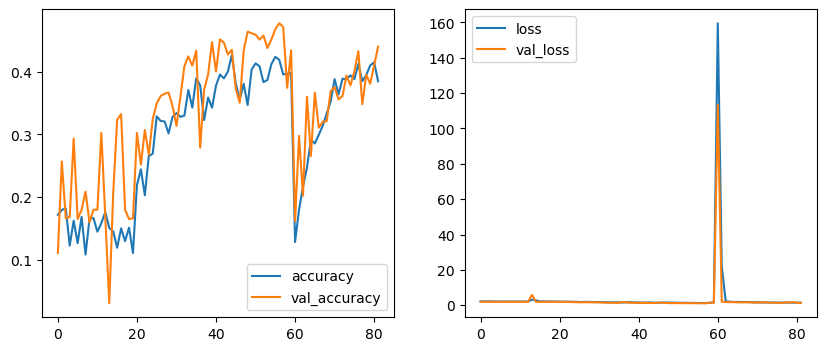

In [38]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].legend(['accuracy', 'val_accuracy'])

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].legend(['loss', 'val_loss'])
plt.show()

In [28]:
model.evaluate(valid_loader)


22/22 [==============================] - 8s 346ms/step - loss: 2.1832 - accuracy: 0.0997 - precision_4: 0.0595 - recall_4: 0.0145


[2.1831796169281006,
 0.09971098601818085,
 0.0595238097012043,
 0.014450866729021072]

22/22 [==============================] - 8s 354ms/step


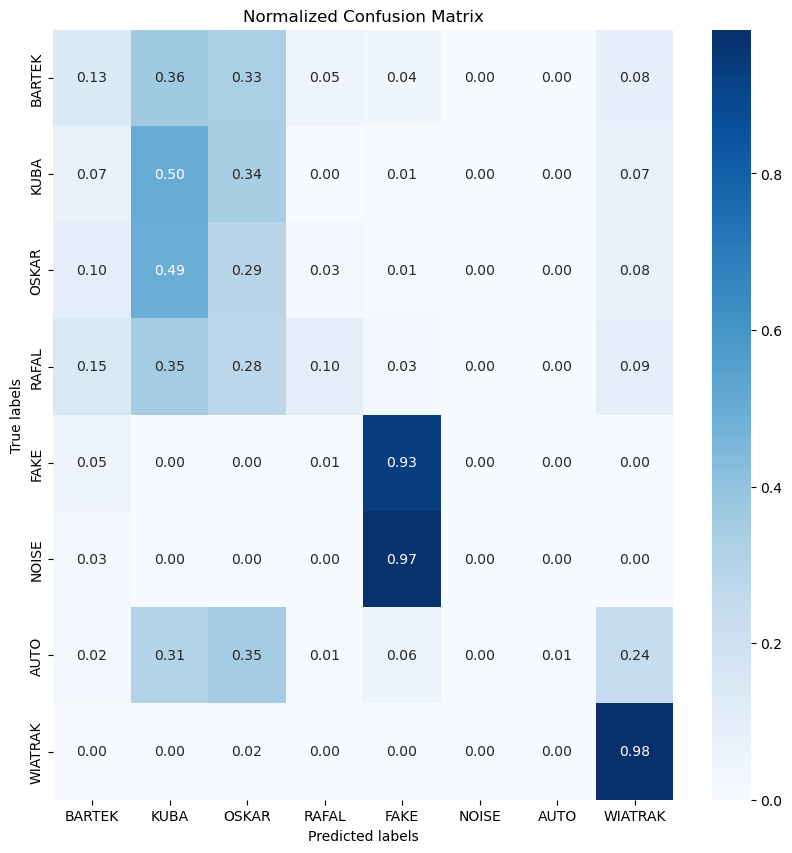

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

classes = ['BARTEK', 'KUBA', 'OSKAR', 'RAFAL', 'FAKE', 'NOISE', 'AUTO', 'WIATRAK']

# Assuming you have already trained the model
y_pred = model.predict(valid_loader)
y_pred = np.argmax(y_pred, axis=1)
y_true = valid_loader.labels
y_true = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap='Blues', fmt='.2f')
# sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='.2f')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()